# WMIR practice lesson

### Objective
Train an SVM model on different datasets, optimized some parameters and compare the different outcomes.  
We will use the 20newsgroups dataset and the QuestionClassification.

#### Author
Claudiu Daniel Hromei, March 2023.


# Required Libraries

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [2]:
# option to print all the value of cells in DataFrames
pd.set_option("max_colwidth", None)

# 20newsgroup dataset
Load the dataset and print the classes

In [3]:
# Load the Reuters dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

classes = list(newsgroups_train.target_names)
pprint(classes)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


Let's see the first example. It's a letter form.

In [4]:
print("SHAPE ", newsgroups_train.filenames.shape)
print("----------------------------------------")
print(newsgroups_train.data[0])
print("----------------------------------------")
print(newsgroups_train.target[0], "=>", classes[newsgroups_train.target[0]])

SHAPE  (11314,)
----------------------------------------
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
----------------------------------------
7 => rec.autos


We can plot the number of examples for each class.

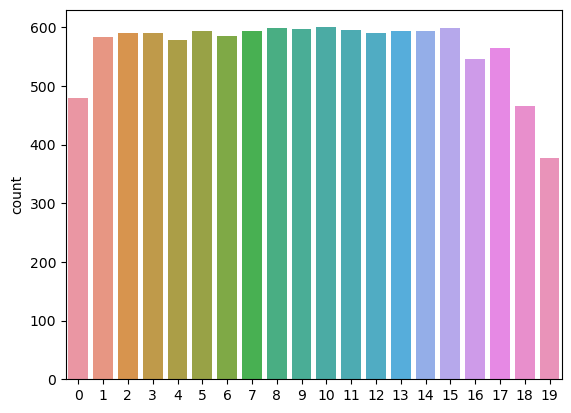

In [5]:
training_plot = sns.countplot(x=sorted(newsgroups_train.target))

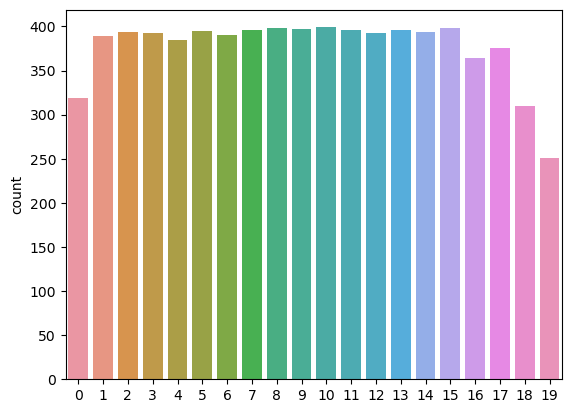

In [6]:
testing_plot = sns.countplot(x=sorted(newsgroups_test.target))

### Preprocessing
Preprocess every example: remove stopwords and compute the Tf-idf (term frequencyinverse-document-frequency) vector representation.

Il metodo transform, invece, viene utilizzato per applicare il pre-processore addestrato sui dati di input senza doverlo addestrare di nuovo. In altre parole, questo metodo applica solo la trasformazione dei dati utilizzando il pre-processore addestrato. Questo metodo può essere utilizzato su qualsiasi set di dati, compresi i dati di addestramento, validazione e test.

In generale, si utilizza fit_transform solo sul set di addestramento e transform sui set di validazione e test. Questo perché il set di addestramento viene utilizzato per addestrare il pre-processore, mentre i set di validazione e test vengono utilizzati per valutare le prestazioni del modello addestrato. Addestrare il pre-processore sui dati di validazione e test potrebbe condurre a una valutazione ottimistica del modello e a una scarsa generalizzazione su nuovi dati.

In [7]:
# Extract features from the dataset
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

(0, 59071)	0.10043853867312116 

(numero frase, indice della parola)  valore tf-idf

In [8]:
print(X_train[:3])

  (0, 59071)	0.10043853867312116
  (0, 57250)	0.1063473585616558
  (0, 41874)	0.224548896412017
  (0, 49800)	0.11869932893481257
  (0, 46690)	0.12504220873599214
  (0, 73174)	0.16142029533900565
  (0, 99608)	0.09418459052541318
  (0, 84050)	0.16329311028814825
  (0, 37208)	0.1434127293323407
  (0, 62594)	0.13037295035007848
  (0, 87913)	0.25808578247347563
  (0, 54493)	0.06961997844491917
  (0, 23430)	0.12937103288512333
  (0, 77676)	0.12197186951739486
  (0, 81450)	0.1461308934288897
  (0, 24583)	0.19644480500804062
  (0, 16806)	0.1407774554706102
  (0, 83208)	0.11339406589538423
  (0, 76269)	0.08978258481915573
  (0, 34742)	0.17300821242559045
  (0, 24108)	0.24723134514216435
  (0, 25437)	0.10548299054214269
  (0, 11174)	0.20599311323287353
  (0, 35902)	0.1266709604197344
  (0, 9843)	0.20797700857530224
  :	:
  (2, 58818)	0.11421411941756535
  (2, 65475)	0.038575837206097384
  (2, 59552)	0.06356310743922607
  (2, 83714)	0.11145632172819905
  (2, 3483)	0.0792685643310162
  (2, 95674)	

In [15]:
X_test = vectorizer.fit_transform(newsgroups_test.data)
print(X_test[:3])

  (0, 16133)	0.1144732993064222
  (0, 14333)	0.09844986558140172
  (0, 60329)	0.15127919835277626
  (0, 24578)	0.12504193811710265
  (0, 59060)	0.154496674324282
  (0, 42468)	0.16245214545485673
  (0, 69661)	0.09884758339103851
  (0, 62445)	0.14694584012653766
  (0, 22006)	0.1645281631086111
  (0, 68088)	0.12138287073835989
  (0, 65274)	0.11903526552823593
  (0, 43156)	0.12821496442109803
  (0, 50486)	0.23949392788232454
  (0, 65680)	0.26049321690942895
  (0, 15165)	0.22012039735034716
  (0, 37689)	0.06748384514301242
  (0, 20791)	0.15171511407011876
  (0, 48816)	0.13203603341737688
  (0, 27390)	0.1416421867490244
  (0, 27187)	0.1001990479065971
  (0, 22765)	0.154496674324282
  (0, 61705)	0.09884758339103851
  (0, 59218)	0.23949392788232454
  (0, 59216)	0.23949392788232454
  (0, 39842)	0.23949392788232454
  :	:
  (1, 18976)	0.2202902596368726
  (1, 18979)	0.15565699920530787
  (1, 40981)	0.1472612252142544
  (1, 26990)	0.16840330044265578
  (1, 64462)	0.18185253134373225
  (1, 23252)	0

We can print the vocabulary to see what is contained inside. It is defined as `key:value` pairs, where the `key` is the word from the texts and the `value` is the index in the matrix for the tf-idf computation.

In [8]:
print(vectorizer.vocabulary_)

{'wondering': 96879, 'enlighten': 37256, 'car': 25717, 'saw': 80420, 'day': 31927, 'door': 34741, 'sports': 84312, 'looked': 57247, 'late': 55606, '60s': 9843, 'early': 35902, '70s': 11174, 'called': 25437, 'bricklin': 24108, 'doors': 34742, 'really': 76269, 'small': 83208, 'addition': 16806, 'bumper': 24583, 'separate': 81450, 'rest': 77676, 'body': 23430, 'know': 54493, 'tellme': 87913, 'model': 62594, 'engine': 37208, 'specs': 84050, 'years': 99608, 'production': 73174, 'history': 46690, 'info': 49800, 'funky': 41874, 'looking': 57250, 'mail': 59071, 'fair': 39296, 'number': 66680, 'brave': 23973, 'souls': 83779, 'upgraded': 92389, 'si': 82337, 'clock': 27889, 'oscillator': 68519, 'shared': 81848, 'experiences': 38637, 'poll': 72039, 'send': 81378, 'brief': 24125, 'message': 60923, 'detailing': 33127, 'procedure': 73122, 'speed': 84088, 'attained': 20236, 'cpu': 30233, 'rated': 75904, 'add': 16791, 'cards': 25769, 'adapters': 16776, 'heat': 45997, 'sinks': 82666, 'hour': 47310, 'usa

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

In [13]:
indexs = [59071, 57250, 41874, 49800, 46690, 73174, 99608, 84050, 37208, 62594, 87913, 54493, 23430, 77676, 81450, 24583, 16806, 83208, 76269, 34742, 24108, 25437, 11174, 35902, 9843]

for i in indexs:
    for e in vectorizer.vocabulary_:
        if i==vectorizer.vocabulary_[e]:
            print(e)
            break

mail
looking
funky
info
history
production
years
specs
engine
model
tellme
know
body
rest
separate
bumper
addition
small
really
doors
bricklin
called
70s
early
60s


Let's retrieve the score of the word 'wondering'. We need to take the `index` from the vocabulary and then print the corresponding value.

In [9]:
print("The score of the word 'wondering' for a sentence in which it occurs", \
      X_train[0, vectorizer.vocabulary_['wondering']])

print("The score of the word 'wondering' for a sentence in which it DOES NOT occur", \
      X_train[1, vectorizer.vocabulary_['wondering']])

print("The score of the word 'wondering' for a sentence in which it occurs, but it's less frequent", \
      X_train[2, vectorizer.vocabulary_['wondering']])

The score of the word 'wondering' for a sentence in which it occurs 0.13703598126117264
The score of the word 'wondering' for a sentence in which it DOES NOT occur 0.0
The score of the word 'wondering' for a sentence in which it occurs, but it's less frequent 0.06376456586140074


### Support Vector Machines (BoW)

Definition of the model using the Bag-of-Words (tf-idf) formulation from previous exercises in order to compute some hyperplanes for the classification.  

As an example, we would like something like the space in this image (for illustrations purposes only).
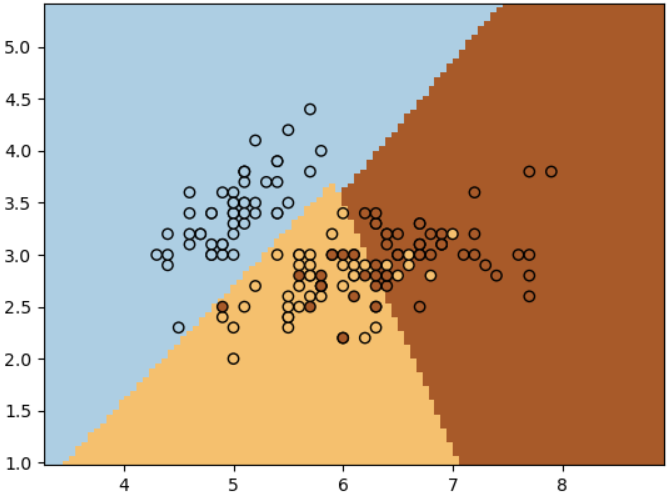

An overview of the main parameters:

- **C**: `float`, default=`1.0`  
Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

- **kernel**: `{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}` or callable, default=`'rbf'`  
Specifies the kernel type to be used in the algorithm. If none is given, `‘rbf’` will be used. If a callable is given it is used to pre-compute the kernel matrix from data matrices; that matrix should be an array of shape `(n_samples, n_samples)`.

- **degree**: `int`, default=`3`  
Degree of the polynomial kernel function (`‘poly’`). Must be non-negative. Ignored by all other kernels.

- **gamma**: `{‘scale’, ‘auto’}` or `float`, default=`’scale’`  
Kernel coefficient for `‘rbf’`, `‘poly’` and `‘sigmoid’`.

  - if gamma = `'scale'` (default) is passed then it uses `1 / (n_features * X.var())` as value of gamma,
  - if `‘auto’`, uses `1 / n_features`
  - if `float`, must be non-negative.

- **verbose**: `bool`, default=`False`  
Enable verbose output. Note that this setting takes advantage of a per-process runtime setting in libsvm that, if enabled, may not work properly in a multithreaded context.

- **max_iter**: `int`, default=`-1`  
Hard limit on iterations within solver, or `-1` for no limit.

- **decision_function_shape**: `{‘ovo’, ‘ovr’}`, default=`’ovr’`  
Whether to return a one-vs-rest (`‘ovr’`) decision function of shape `(n_samples, n_classes)` as all other classifiers, or the original one-vs-one (`‘ovo’`) decision function of libsvm which has shape `(n_samples, n_classes * (n_classes - 1) / 2)`. However, note that internally, one-vs-one (`‘ovo’`) is always used as a multi-class strategy to train models; an ovr matrix is only constructed from the ovo matrix. The parameter is ignored for binary classification.

Notice that we are using a `linear` version of the SVM model, so the `degree` and `gamma` params will be ignored.

In [10]:
C = 1
decision_function_shape = 'ovo' 
max_iter = 10000
kernel = "linear"
degree = 3
gamma = 0.7
svm = SVC(C=C, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)

svm.fit(X_train, y_train)

SVC(C=1, decision_function_shape='ovo', gamma=0.7, kernel='linear',
    max_iter=10000)

In [11]:
y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred, target_names=classes))

                          precision    recall  f1-score   support

             alt.atheism       0.47      0.48      0.47       319
           comp.graphics       0.61      0.72      0.66       389
 comp.os.ms-windows.misc       0.65      0.61      0.63       394
comp.sys.ibm.pc.hardware       0.65      0.67      0.66       392
   comp.sys.mac.hardware       0.75      0.66      0.71       385
          comp.windows.x       0.86      0.66      0.75       395
            misc.forsale       0.77      0.79      0.78       390
               rec.autos       0.64      0.72      0.68       396
         rec.motorcycles       0.45      0.79      0.58       398
      rec.sport.baseball       0.81      0.77      0.79       397
        rec.sport.hockey       0.92      0.82      0.87       399
               sci.crypt       0.90      0.68      0.78       396
         sci.electronics       0.55      0.61      0.58       393
                 sci.med       0.77      0.75      0.76       396
         

### EXERCISE 1: Find the best value of C parameter

Find the best value of *C* parameter in order to maximize the F1 score. Use a 10 fold cross-validation policy, save all the scores and plot the mean of the folds for every value. Discuss briefly the results. 

Example: 
- C=0.1: fold_1 = 0.63; fold_2 = 0.66; fold_3 = 0.68; fold_4 = 0.66; fold_5 = 0.68; ... → mean = 0.662
- C=0.2: fold_1 = 0.64; fold_2 = 0.67; fold_3 = 0.69; fold_4 = 0.66; fold_5 = 0.69; ... → mean = 0.67  

Quando si effettua la cross_val_score non bisogna fare il fit del modello poichè è già contenuto all'interno della cross validation.

In [ ]:
c_value = [0.01, 0.1, 1, 2, 3, 4, 5]
max_iter = 10000

results = []
for c in c_value:
    svm = SVC(C=c, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
        
    scores = cross_val_score(estimator=svm, X=X_train[:1000], y=y_train[:1000], cv=10, scoring='f1_weighted')
    print('f1')
    print(scores)
    results.append([c, scores.mean()])


print(results)
    #y_pred = svm.predict(X_test)
    #print(classification_report(y_test, y_pred, target_names=classes))

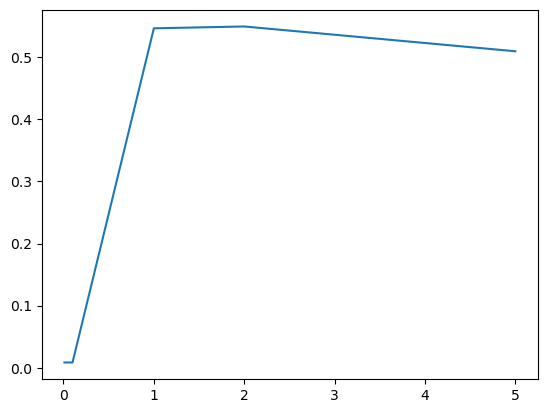

In [20]:
cs = []
f1s = []
for r in results:
    cs.append(r[0])
    f1s.append(r[1])
    
plt.plot(cs, f1s)
plt.show()

### EXERCISE 2: Plot the learning curve

Plot the learning curve of the *SVM* model for an increasing size of the training set. Show the F1 score obtained on the test set given the best value of *C* from the previous exercise.

Hint:
- take the **same** test set and value of *C* from the previous exercise
- take increasing sizes of the training set (10%, 20%, ..., 90%, 100%), train the *SVM* model and evaluate it on the test set
- save the performance
- make a plot

In [ ]:
c= 2

x_train_10_percent = X_train.sample(frac=0.1, random_state=1)
y_train_10_percent = y_train.iloc[x_train_10_percent.index]
svm = SVC(C=c, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)
svm.fit(x_train_10_percent, y_train_10_percen)

y_pred = svm.predict(X_test)
f1_score(y_true, y_pred, average='weighted')

# Question Classification dataset
We will use a different dataset, whose objective is to classify the given Questions into respective categories based on what type of answer it expects such as a numerical answer or a text description or a place or human name etc.
Load the dataset and print the classes

In [ ]:
training_data = pd.read_csv("./data/train.csv")
testing_data = pd.read_csv("./data/test.csv")

classes_qc = list(np.unique(testing_data['classes']))
print(classes_qc)

Let's see some examples.

In [ ]:
training_data.head(10)

We can plot the number of examples for each class.

In [ ]:
training_plot = sns.countplot(x=sorted(training_data['classes']))

In [ ]:
testing_plot = sns.countplot(x=sorted(testing_data['classes']))

### SVM - BoW

Let's apply again the Bag-of-Word (tf-idf) policy to encode these sentences and evaluate an SVM model.

In [ ]:
# Extract features from the dataset
vectorizer = TfidfVectorizer(stop_words='english')
X_train_qc = vectorizer.fit_transform(training_data['questions'].tolist())
X_test_qc = vectorizer.transform(testing_data['questions'].tolist())
y_train_qc = training_data['classes'].tolist()
y_test_qc = testing_data['classes'].tolist()

In [ ]:
C = 1
decision_function_shape = 'ovo' 
max_iter = 10000
kernel = "linear"
degree = 3
gamma = 0.7
svm_qc = SVC(C=C, max_iter=max_iter, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)

svm_qc.fit(X_train_qc, y_train_qc)

In [ ]:
y_pred_qc = svm_qc.predict(X_test_qc)

print(classification_report(y_test_qc, y_pred_qc, target_names=classes_qc))

### Support Vector Machines (Neural Encoding)

Definition of the model using a different policy to compute the representation of the test. Recently, advanced models were introduced,  called [Transformers](https://jalammar.github.io/illustrated-transformer/) able to represent words in context (in the sentence): e.g. the word *bank* has at least two differnt meanings, depending on the sentence in which is found "*The **bank** of the river.*" or "*I asked the **bank** for a loan*". These Transformers will produce different representations based on the context. On the other hand, the classic Bag-of-Words approach will produce the same representation either for the side of the river and the financial institution.

We can leverage the ability of the Transformers in order to produce the numerical representation of the sentences from our dataset and then use the SVM model for classification. The `get_embeddings` method here calls the Transformer named `'msmarco-distilbert-base-v2'` to get the numerical representation in a similar manner as we called the Vectorizer to produce the `tf-idf` vectors previously.  

More about the Transformers topic in the next lessons!

---

**WARNING**: you need to activate the GPU setting for this notebook. If you're using the Jupyter Notebook Environment pass over this, if you're using the Google Colab environment you need to:  
- click on "*Runtime*"
- click on "*Change Runtime type*"
- on "*Hardware accelerator*" choose "*GPU*" from the dropdown list
- click on *Save* and run this Notebook again

I already computed this embeddings and we will load them from file. If you want to use this model and compute them for yourself, execute this in a code cell:

```
# install the library
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer
import torch

def get_embeddings(sentences: List[str]) -> List[float]:
    model = SentenceTransformer('msmarco-distilbert-base-v2')
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    return model.encode(sentences, batch_size=640, device="cuda:0", show_progress_bar=True).tolist()

X_train_sbert = get_embeddings(newsgroups_train.data)
X_test_sbert = get_embeddings(newsgroups_test.data)
```

Load the embeddings from file here and print the first question and its embedding.

In [ ]:
X_train_sbert = []
with open("./data/train_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_train_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])
    
X_test_sbert = []
with open("./data/test_embeddings_sbert.txt") as f:
    lines = f.readlines()
    for line in lines:
        X_test_sbert.append([float(x) for x in line.rstrip().lstrip().split(" ")])

In [ ]:
print(training_data['questions'].tolist()[0], "\n", X_train_sbert[0])

Now we train an SVM model

In [ ]:
svm_with_sbert = SVC(C=C, degree=degree, kernel=kernel, gamma=gamma, decision_function_shape=decision_function_shape)

svm_with_sbert.fit(X_train_sbert, y_train_qc)

In [ ]:
y_pred_qc_sbert = svm_with_sbert.predict(X_test_sbert)

print(classification_report(y_test_qc, y_pred_qc_sbert, target_names=classes_qc))

# Feature selection

The objective is to reduce the number of input features and select the most important and informative features. As we saw in previous sections, the BoW with tf-idf policy is introducing **a lot** of feature (*8181*).

One "simple" way is to use the Mutual Information (MI): a measure of the mutual dependence between two random variables. In this context, MI is used to measure the amount of information that a feature (in our case the value of a word) provides about the target variable (the target class). The idea is that features that have high MI with the target variable are more informative and useful for prediction than features with low MI.

To apply Mutual Information for feature selection, you can use the following steps:
1. Compute the Mutual Information between each feature and the target variable.
2. Rank the features in decreasing order of MI scores.
3. Select the top N features with the highest MI scores.

There are different methods to compute MI, such as using the entropy-based method or the Kullback-Leibler (KL) divergence. In practice, the scikit-learn library in Python provides several methods for feature selection using MI, such as mutual_info_classif, mutual_info_regression, and SelectKBest.

### EXERCISE 3: Select the best Features

Use the Mutual Information policy to score the features and select the best *K* (motivate the value of *K*). Train the SVM model again and compare the performance with the original one.

Hint: Extract the vocabulary from the `vectorizer`, compute some score to rank the features, delete the worst ones and add it back with:

```
new_vectorizer = TfidfVectorizer(vocabulary=new_vocabulary)
new_X_train = new_vectorizer.transform(X_train)
new_X_test = new_vectorizer.transform(X_test)
```

### EXERCISE 4: Compare with another model type

Compare the best model you found today (based on *SVM*) with anot